# MFPT problem of RTPs with a partially absorbing boundary

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Monte-Carlo MFPT =   8.9942
Analytic MFPT =   9.0000
Monte-Carlo variance =  73.5361


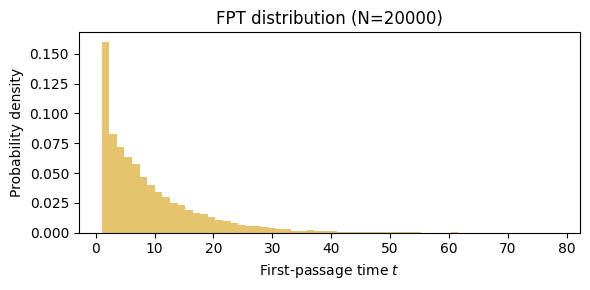

In [15]:
def simulate_fpt_rtp(L=20.0, v=5.0, alpha=2.0,
                     kappa0=np.inf,        # surface absorption rate
                     x0=0.3,               # start position
                     n_particles=20_000,   # Monte-Carlo sample size
                     max_time=100.0):
    """
    Return an array of first-passage times for a 1-D RTP with:
        • reflecting wall at x=0
        • partially absorbing wall at x=L   (Bernoulli prob eta = kappa0/(kappa0+v))
    A value of np.inf for kappa0 produces a perfectly absorbing wall.
    """
    if np.isinf(kappa0):
        eta = 1.0                 # always absorb when x = L is hit
    else:                         # radiation (Robin) condition → Bernoulli absorption
        eta = kappa0 / (kappa0 + v)

    fpt = np.empty(n_particles)

    for i in range(n_particles):
        x = x0
        sigma = 1 if np.random.rand() < 0.5 else -1      # initial direction
        t = 0.0

        while t < max_time:
            # next tumble time
            tau_tumble = np.random.exponential(1/alpha)
            # time to the next boundary in the current direction
            tau_wall = (L - x)/v if sigma == 1 else x/v
            tau = min(tau_tumble, tau_wall)

            t += tau
            x += sigma * v * tau

            # check which event happened
            hit_wall = tau_wall < tau_tumble

            if hit_wall:
                if sigma == 1:                 # hit the partially absorbing wall x = L
                    if np.random.rand() < eta:
                        fpt[i] = t             # absorbed
                        break
                    sigma = -1                 # reflected
                else:                          # hit the reflecting wall x = 0
                    sigma =  1
            else:                              # a tumble in the bulk
                sigma *= -1
        else:
            fpt[i] = np.nan                    # safety cutoff hit

    return fpt[~np.isnan(fpt)]                 # drop rare cut-off cases


L, v, alpha = 10.0, 5.0, 1.0
x0 = 5.0
kappa0 = 5
N = 20000

fpt_sample = simulate_fpt_rtp(L, v, alpha, kappa0, x0, N)
mfpt_mc = np.mean(fpt_sample)
var_mc = np.var(fpt_sample)

# analytic MFPT for perfectly absorbing wall
D0 = v**2 / (2*alpha)
mfpt_exact = L/v + (L**2 - x0**2)/(2*D0) + 2*L/kappa0

print(f"Monte-Carlo MFPT = {mfpt_mc:8.4f}")
print(f"Analytic MFPT = {mfpt_exact:8.4f}")
print(f"Monte-Carlo variance = {var_mc:8.4f}")

# quick visual check
plt.figure(figsize=(6,3))
plt.hist(fpt_sample, bins=60, density=True, alpha=0.65, color="goldenrod")
plt.xlabel("First-passage time $t$")
plt.ylabel("Probability density")
plt.title(f"FPT distribution (N={N})")
plt.tight_layout()
plt.show()

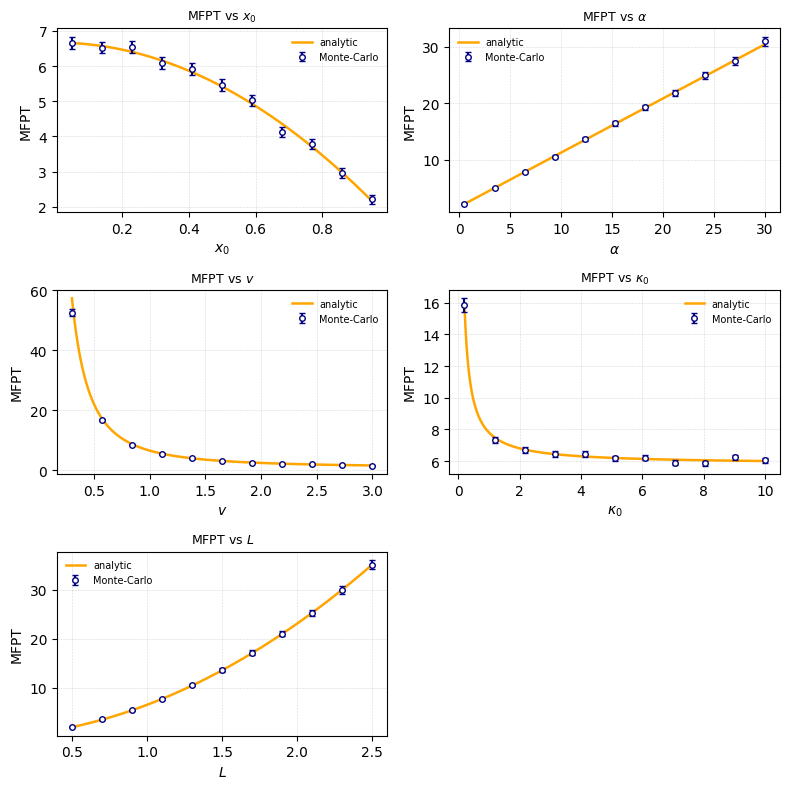

In [ ]:
# analytic MFPT
def mfpt(x0, alpha, v, kappa0, L):
    D0 = v**2 / (2*alpha)
    return 2*L/kappa0 + L/v + (L**2 - x0**2)/(2*D0)

# Monte-Carlo trajectory sampler 
def traj_fpt(L, v, alpha, kappa0, x0, n, Tmax=200):
    """Return n first-passage times (array length n)."""
    eta = 1.0 if np.isinf(kappa0) else kappa0/(kappa0+v)
    out = np.empty(n)
    for k in range(n):
        x, t = x0, 0.0
        sig = 1 if np.random.rand() < 0.5 else -1
        while t < Tmax:
            tau_t = np.random.exponential(1/alpha)
            tau_w = (L-x)/v if sig==1 else x/v
            tau = tau_t if tau_t < tau_w else tau_w
            t += tau
            x += sig*v*tau
            if tau == tau_w:                          # hit wall
                if sig==1 and np.random.rand() < eta: # absorption test
                    out[k] = t; break
                sig *= -1                             # reflection
            else:
                sig *= -1                             # tumble
    return out

# Parameters & sweep vectors
base = dict(x0=0.2, alpha=5.0, v=1.0, kappa0=3.0, L=1.0)
sweeps = {
    "x0": np.linspace(0.05, 0.95, 300),
    "alpha": np.linspace(0.5, 30, 300),
    "v": np.linspace(0.3, 3, 300),
    "kappa0": np.linspace(0.2, 10, 300),
    "L": np.linspace(0.5, 2.5, 300)
}
labels = {
    "x0": r"$x_0$",
    "alpha": r"$\alpha$",
    "v": r"$v$",
    "kappa0": r"$\kappa_0$",
    "L": r"$L$"
}

# plot: 3 × 2 
fig, axs = plt.subplots(3, 2, figsize=(8, 8))
axs = axs.flatten()

for idx, (key, x_vec) in enumerate(sweeps.items()):
    # analytic curve 
    par = {k: np.full_like(x_vec, val) for k, val in base.items()}
    par[key] = x_vec
    tau_curve = mfpt(par["x0"], par["alpha"], par["v"],
                     par["kappa0"], par["L"])
    axs[idx].plot(x_vec, tau_curve, color="orange", lw=1.8,
                  label="analytic")
    
    # Monte-Carlo checkpoints
    xp = np.linspace(x_vec.min(), x_vec.max(), 11)  # 11 sample points
    par_MC = {k: np.full_like(xp, val) for k, val in base.items()}
    par_MC[key] = xp
    tau_MC = np.zeros_like(xp)
    err_MC = np.zeros_like(xp)
    Nsample = 4000  # trajectories per sample point
    
    for j, xx in enumerate(xp):
        sample = traj_fpt(L=par_MC["L"][j],
                          v=par_MC["v"][j],
                          alpha=par_MC["alpha"][j],
                          kappa0=par_MC["kappa0"][j],
                          x0=par_MC["x0"][j],
                          n=Nsample)
        tau_MC[j] = sample.mean()
        err_MC[j] = 1.96 * sample.std(ddof=1) / np.sqrt(Nsample)
    
    axs[idx].errorbar(xp, tau_MC, yerr=err_MC,
                      fmt="o", ms=4, mec="navy",
                      mfc="white", ecolor="navy",
                      capsize=2, label="Monte-Carlo")

    axs[idx].set_xlabel(labels[key])
    axs[idx].set_ylabel("MFPT")
    axs[idx].set_title(f"MFPT vs {labels[key]}", fontsize=9)
    axs[idx].grid(lw=0.4, ls="--", alpha=0.5)
    axs[idx].legend(frameon=False, fontsize=7)

axs[-1].axis("off")

fig.tight_layout()
plt.show()
